# ◆[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)
### 目的：タイタニック号の乗客のデータから、生存予測をする
- 目的変数をSurvivedとする二値分類問題を勾配ブースティングアルゴリズムを使ってモデルを構築する
##### Create Date：2020/01/08　Author：M.Hasegawa

### ────────────────────────────────────────────────────────────────

#### 【手順】
0. [**Notebook内で利用する関数の定義**](#import_module)
1. [**データ読込**](#import_data)
2. [**特徴量の抽出**](#feature_extraction)
3. [**前処理**](#prepearing)・・・カテゴリ変換
4. [**モデル構築と評価**](#modeling)
5. [**テストデータ予測**](#submission)

#### ※データセット
- 「train.csv」（学習データ数：891行12列）
- 「test.csv」（テストデータ数：418行11列 ※Survived列がない）

| 列 | 項目 | 項目名 | 欠損有無 | 利用有無 |
| :--- | :--- | :--- | :---: | :---: |
|  1 | PassengerId |識別ID | - | - |
|  2 | Survived | 生存有無 | - | ○ |
|  3 | Pclass | チケットクラス | - | ○ |
|  4 | Name | 名前 | - | - |
|  5 | Sex | 性別 | - | ○ |
|  6 | Age | 年齢 | 欠損あり | ○ |
|  7 | SibSp | タイタニック号に乗る兄弟/配偶者の数 | - | ○ |
|  8 | Parch | タイタニック号に乗る親/子供の数 | - | ○ |
|  9 | Ticket | チケット | - | - |
| 10 | Fare | 旅客運賃 | 欠損あり | ○ |
| 11 | Cabin | 客室番号 | 欠損あり | - |
| 12 | Embarked| 乗船港 C =シェルブール、Q =クイーンズタウン、S =サザンプトン | 欠損あり | ○ |

## 0. Notebook内で利用する関数の定義<a id='import_module'></a>

In [1]:
%matplotlib inline
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import math 
import xgboost as xgb
import statsmodels
import numpy as np
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy           import stats
from scipy.stats     import skew
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

np.random.seed(2019)


# ============================================================================
# 関数：各データの件数を確認するグラフ
# 引数：データフレーム、データ名,グラフの横幅、縦幅、降順ソート指定
# ============================================================================
def show_state_count_plot(p_df, col_name, w, h, sort_flg=False):
    plt.figure(figsize=(w,h))
    if(sort_flg):
        print("\n▼ " + str(col_name) + "別の生存数と死亡数（降順）")
        ax = sns.countplot(p_df[col_name],hue=p_df['Survived'],order = p_df[col_name].value_counts().index)
    else:
        print("\n▼ " + str(col_name) + "別の生存数と死亡数 ")
        ax = sns.countplot(p_df[col_name],hue=p_df['Survived'])
        
    ax.set_title("Count by " + str(col_name))
    ax.set_xlabel(col_name)
    ax.set_ylabel("Count")
    plt.grid(which='major',color='gray',linestyle=':')
    plt.grid(which='minor',color='gray',linestyle=':')
    plt.legend()
    plt.show()

# ============================================================================
# 関数：各データの生存率を確認するグラフ
# 引数：データフレーム、データ名,グラフの横幅、縦幅、降順ソート有無
# ============================================================================
def show_s_rate_barplot(p_df, col_name, w, h, sort_flg=False):
    s_rate = pd.DataFrame(p_df['Survived'].groupby(p_df[col_name]).mean())
    s_rate.reset_index(inplace = True) # index振り直し
    if(sort_flg):
        s_rate = s_rate.sort_values('Survived', ascending=False)
        print("\n▼ " + str(col_name) + "別の生存率（降順）※赤線：生存率の平均値")
    else:
        print("\n▼ " + str(col_name) + "別の生存率 ※赤線：生存率の平均値")
    plt.figure(figsize=(w,h))
    ax = sns.barplot(x=col_name, y="Survived", data=s_rate)
    ax.axhline(p_df['Survived'].mean(), alpha=0.5, color='red') # 平均値
    ax.set_title("Survived rate by " + str(col_name))
    plt.grid(which='major',color='lightgray',linestyle=':')
    plt.grid(which='minor',color='lightgray',linestyle=':')
    ax.set_xlabel(col_name)
    ax.set_ylabel("Ratio")
    plt.show()

# 1. データ読込<a id='import_data'><a>


▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化


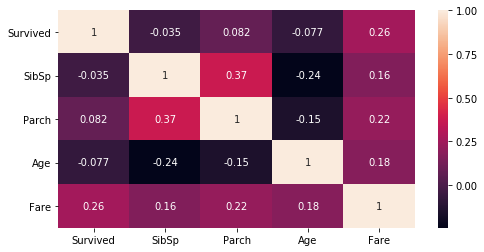

In [2]:
def read_and_concat_dataset(training_path, test_path):
    train = pd.read_csv(training_path)
    train['train'] = 1
    test = pd.read_csv(test_path)
    test['train'] = 0
    data = train.append(test, ignore_index=True)
    return train, test, data

train, test, data = read_and_concat_dataset('./input/train.csv', './input/test.csv')
data = data.set_index('PassengerId')

# ヒートマップ
print('\n▼ 説明変数（数値項目）同士の相関係数をヒートマップにして可視化')
plt.figure(figsize=(8,4))
g = sns.heatmap(data[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True)
plt.show()

In [3]:
def comparing(data,variable1, variable2):
    #print(data[[variable1, variable2]][data[variable2].isnull()==False].groupby([variable1], as_index=False).mean().sort_values(by=variable2, ascending=False))
    g = sns.FacetGrid(data, col=variable2).map(sns.distplot, variable1)
    plt.show()
def counting_values(data, variable1, variable2):
    return data[[variable1, variable2]][data[variable2].isnull()==False].groupby([variable1], as_index=False).mean().sort_values(by=variable2, ascending=False)


# 2. 特徴量の抽出<a id='feature_extraction'></a>
## 2-1. グラフ化


▼ Parch vs Survived


<Figure size 144x144 with 0 Axes>

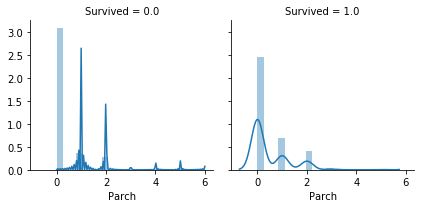


▼ SibSp vs Survived


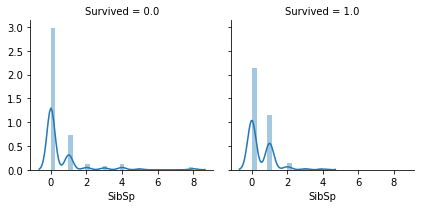


▼ Fare vs Survived


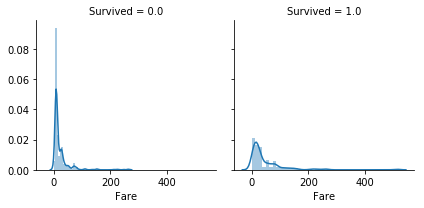


▼ Age vs Survived


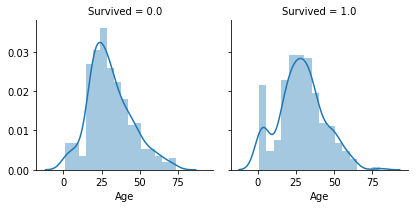


▼ Sex vs Survived


,Sex,Survived
0,female,0.742038
1,male,0.188908



▼ Woman vs Survived


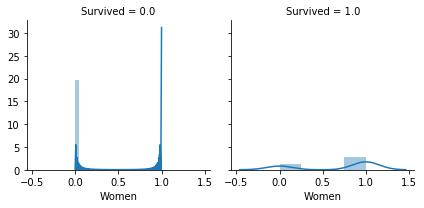


▼ Pclass vs Survived


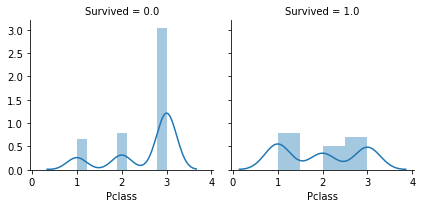


▼ Pclass(Age) vs Survived


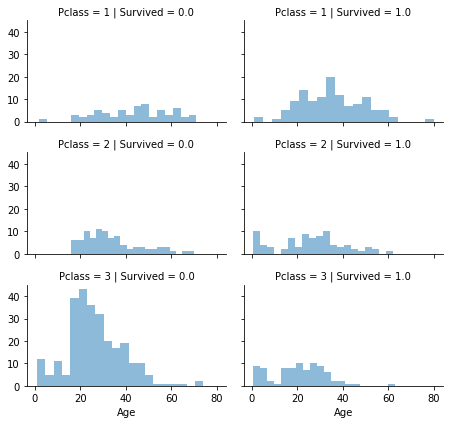


▼ Embarked(Sex) vs Survived


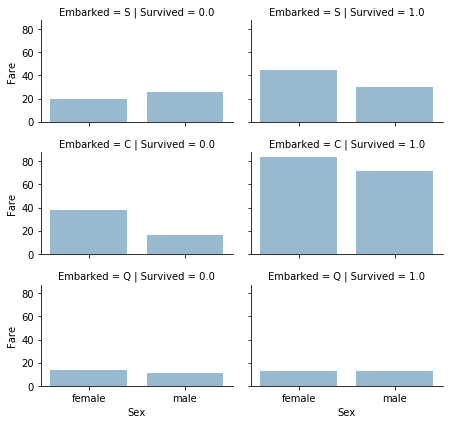

In [4]:
plt.figure(figsize=(2,2))
print('\n▼ Parch vs Survived')
comparing(data, 'Parch','Survived')
print('\n▼ SibSp vs Survived')
comparing(data, 'SibSp','Survived')
print('\n▼ Fare vs Survived')
comparing(data, 'Fare','Survived')
print('\n▼ Age vs Survived')
comparing(data, 'Age','Survived')
print('\n▼ Sex vs Survived')
display(counting_values(data, 'Sex','Survived'))
print('\n▼ Woman vs Survived')
data['Women'] = np.where(data.Sex=='female',1,0) # 女性を1とする列を追加
comparing(data, 'Women','Survived')
print('\n▼ Pclass vs Survived')
comparing(data, 'Pclass','Survived')
print('\n▼ Pclass(Age) vs Survived')
grid = sns.FacetGrid(data, col='Survived', row='Pclass', size=2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
plt.show()
print('\n▼ Embarked(Sex) vs Survived')
grid = sns.FacetGrid(data, row='Embarked', col='Survived', size=2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
plt.show()

## 2-2. 欠損値の補完

In [5]:
display(pd.DataFrame(data.isnull().sum()[data.isnull().sum()>0],columns=['Train Missing num']))

,Train Missing num
Age,263
Cabin,1014
Embarked,2
Fare,1
Survived,418


- 年齢は非常に重要な変数であるため、時間を費やす価値があります。
- キャビンの場合、データセットには1309の観測しかなく、77％のキャビンが欠落しているため、実行が困難です。
- EmbarkedおよびFare変数の欠損値は、最も一般的な値またはそのようなものを使用できるため、入力するのは非常に簡単です。
- 運賃の欠損値を0に、乗車の欠損値を最も一般的な値（'S'）に置き換えます。

In [6]:
# 運賃の欠損値を0にする
data.Fare = data.Fare.fillna(0)

# 乗船港を最頻値のSとする(※data.Embarked.value_counts().index[0]=S)
data.Embarked = data.Embarked.fillna(data.Embarked.value_counts().index[0])

# キャビン変数については、NaN値に「不明」を入力し、データセット内のすべてのキャビンから最初の文字を取得します。
data.Cabin = data.Cabin.fillna('Unknown')
data['Cabin'] = data['Cabin'].str[0]

# 個々の乗客クラスのキャビンの分布を確認
display(pd.DataFrame(data.groupby('Pclass').Cabin.value_counts(),columns=['Pclass','Cabin']))

Pclass  Cabin
Pclass Cabin              
1      C        NaN     94
       U        NaN     67
       B        NaN     65
       D        NaN     40
       E        NaN     34
       A        NaN     22
       T        NaN      1
2      U        NaN    254
       F        NaN     13
       D        NaN      6
       E        NaN      4
3      U        NaN    693
       F        NaN      8
       G        NaN      5
       E        NaN      3

In [7]:
# キャビンの欠損は、Pclass1ではC、Pclass2ではD、Pcalss3ではGに設定されます。
#キャビン「T」の見解は、Pclass1クラスなのでCに修正する
data['Cabin'] = np.where((data.Pclass==1) & (data.Cabin=='U'),'C',
                np.where((data.Pclass==2) & (data.Cabin=='U'),'D',
                np.where((data.Pclass==3) & (data.Cabin=='U'),'G',
                np.where(data.Cabin=='T','C',data.Cabin))))

In [8]:
# 次に、データセットの各名前からタイトルを取得します。
# Ageに欠損値を代入するのに役立ちます。
# 人々の称号は、年齢、収入、および生活状態を表すことができ、これら3つの特性はすべて、
# 船上での生存の可能性と関連付けることができます。
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
display(pd.crosstab(data['Title'], data['Sex']))
data = data.drop('Name',axis=1)

# 置換（４種類）
data['Title'] = np.where((data.Title=='Capt') | (data.Title=='Countess') | (data.Title=='Don') | (data.Title=='Dona')
                        | (data.Title=='Jonkheer') | (data.Title=='Lady') | (data.Title=='Sir') | (data.Title=='Major') 
                        | (data.Title=='Rev') | (data.Title=='Col'),'Other',data.Title)
data['Title'] = data['Title'].replace('Ms','Miss')
data['Title'] = data['Title'].replace('Mlle','Miss')
data['Title'] = data['Title'].replace('Mme','Mrs')

Sex,female,male
Title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


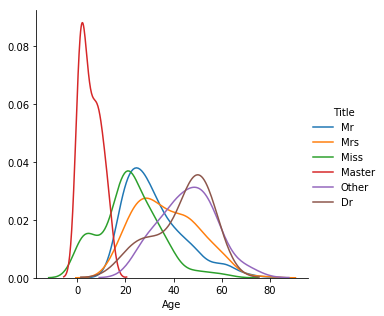

In [9]:
# 称号に応じて生存変数の分布を確認してみましょう。
data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
facet = sns.FacetGrid(data = data, hue = "Title", legend_out=True, size = 4.5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

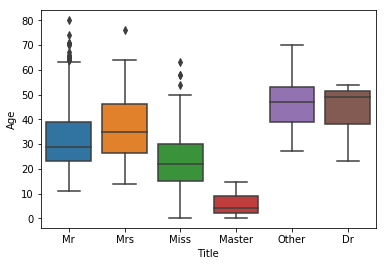

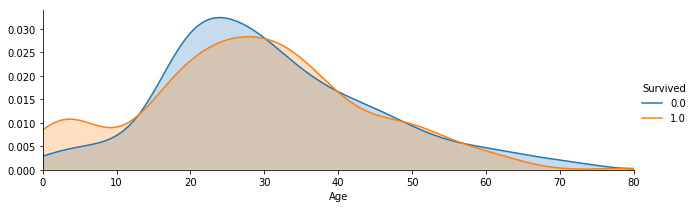

In [10]:
# Masterを持つ人々の生存率は最も高くなります。主に13歳未満の男の子
sns.boxplot(data = data, x = "Title", y = "Age")
plt.show()

facet = sns.FacetGrid(data, hue="Survived",aspect=3)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, data['Age'].max()))
facet.add_legend()

In [11]:
# 年齢は生存率に非常に大きな影響を及ぼしますが、この変数に欠損値がある場合は役に立ちません。
# タイトルに起因する特定のグループの平均年齢値を使用して、欠損値を補完します。
print(data.groupby('Title').Age.mean())

data['Age'] = np.where((data.Age.isnull()) & (data.Title=='Master'),5,
              np.where((data.Age.isnull()) & (data.Title=='Miss'),22,
              np.where((data.Age.isnull()) & (data.Title=='Mr'),32,
              np.where((data.Age.isnull()) & (data.Title=='Mrs'),37,
              np.where((data.Age.isnull()) & (data.Title=='Other'),45,
              np.where((data.Age.isnull()) & (data.Title=='Dr'),44,data.Age))))))                   

Title
Dr        43.571429
Master     5.482642
Miss      21.824366
Mr        32.252151
Mrs       36.918129
Other     45.714286
Name: Age, dtype: float64


## 2-3. 説明変数の追加

In [12]:
# 家族の数
data['FamilySize'] = data.SibSp + data.Parch + 1

# 母親-夫人の肩書きを持つ女性
data['Mother'] = np.where((data.Title=='Mrs') & (data.Parch >0),1,0)

# 運賃を払う必要のない人々（船員や従業員等）
data['Free'] = np.where(data['Fare']==0, 1,0)

# 抽出元のデータを削除
data = data.drop(['SibSp','Parch','Sex'],axis=1)

# Ticketに関しては、敬称の場合と同じように、この変数のいくつかの値を「その他」の値に置き換えます。
import string
TypeOfTicket = []
for i in range(len(data.Ticket)):
    ticket = data.Ticket.iloc[i]
    # 1文字ずつチェックする
    for c in string.punctuation: # 英数字以外のアスキー文字（!"#$%&'・・・）
        ticket = ticket.replace(c,"") # アスキー文字を除去
        
    splited_ticket = ticket.split(" ")# スペースで区切る
    if len(splited_ticket) == 1:
        # チケット番号が数字の場合
        TypeOfTicket.append('NO')
    else: 
        TypeOfTicket.append(splited_ticket[0])
            
data['TypeOfTicket'] = TypeOfTicket
#display(data.TypeOfTicket.value_counts())
data['TypeOfTicket'] = np.where((data.TypeOfTicket!='NO') & (data.TypeOfTicket!='PC') & (data.TypeOfTicket!='CA') & 
                                (data.TypeOfTicket!='A5') & (data.TypeOfTicket!='SOTONOQ'),'other',data.TypeOfTicket)
display(data.TypeOfTicket.value_counts())
data = data.drop('Ticket',axis=1)

# 年齢のビギニング
bins = [0,12,24,45,60,data.Age.max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
data["Age"] = pd.cut(data["Age"], bins, labels = labels)

NO         961
other      136
PC          92
CA          68
A5          28
SOTONOQ     24
Name: TypeOfTicket, dtype: int64

## 2-4. 目的変数（Survived）と説明変数（追加分）の関係


▼ FamilySize別の生存数と死亡数 


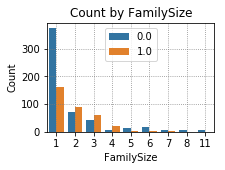


▼ FamilySize別の生存率 ※赤線：生存率の平均値


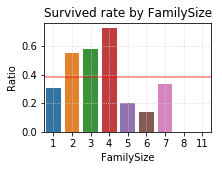


▼ Title別の生存数と死亡数 


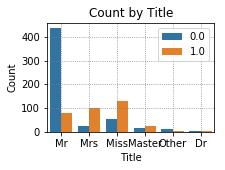


▼ Title別の生存率 ※赤線：生存率の平均値


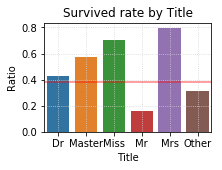


▼ TypeOfTicket別の生存数と死亡数 


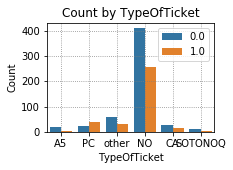


▼ TypeOfTicket別の生存率 ※赤線：生存率の平均値


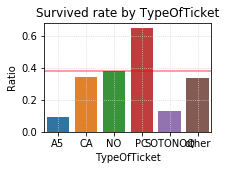


▼ Cabin別の生存数と死亡数 


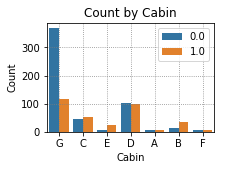


▼ Cabin別の生存率 ※赤線：生存率の平均値


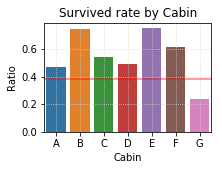


▼ Mother別の生存数と死亡数 


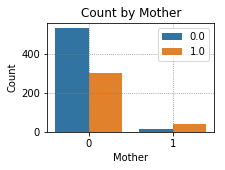


▼ Mother別の生存率 ※赤線：生存率の平均値


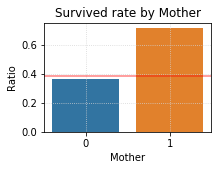


▼ Free別の生存数と死亡数 


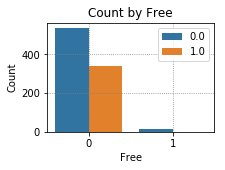


▼ Free別の生存率 ※赤線：生存率の平均値


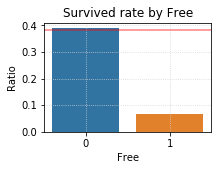


▼ Age別の生存数と死亡数 


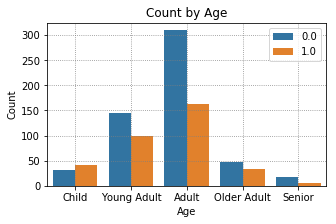


▼ Age別の生存率 ※赤線：生存率の平均値


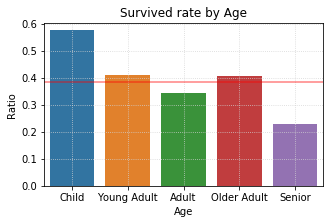

In [13]:
#print('\n▼ FamilySize vs Survived')
show_state_count_plot(data,'FamilySize',3,2)
show_s_rate_barplot(data,'FamilySize',3,2)

#print('\n▼ Title vs Survived')
show_state_count_plot(data,'Title',3,2)
show_s_rate_barplot(data,'Title',3,2)

#print('\n▼ TypeOfTicket vs Survived')
show_state_count_plot(data,'TypeOfTicket',3,2)
show_s_rate_barplot(data,'TypeOfTicket',3,2)

#print('\n▼ Cabin vs Survived')
show_state_count_plot(data,'Cabin',3,2)
show_s_rate_barplot(data,'Cabin',3,2)

#print('\n▼ Mother vs Survived')
show_state_count_plot(data,'Mother',3,2)
show_s_rate_barplot(data,'Mother',3,2)

#print('\n▼ Free vs Survived')
show_state_count_plot(data,'Free',3,2)
show_s_rate_barplot(data,'Free',3,2)

#print('\n▼ Age vs Survived')
show_state_count_plot(data,'Age',5,3)
show_s_rate_barplot(data,'Age',5,3)

# 3. 前処理<a id='prepearing'></a>
## 3-1. ダミー変換

In [14]:
data = pd.get_dummies(data)
display(data.head(5))

,Fare,Pclass,Survived,train,Women,FamilySize,Mother,Free,Age_Child,Age_Young Adult,...,Title_Miss,Title_Mr,Title_Mrs,Title_Other,TypeOfTicket_A5,TypeOfTicket_CA,TypeOfTicket_NO,TypeOfTicket_PC,TypeOfTicket_SOTONOQ,TypeOfTicket_other
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,7.2500,3,0.0,1,0,2,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0
2,71.2833,1,1.0,1,1,2,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,7.9250,3,1.0,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,53.1000,1,1.0,1,1,2,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
5,8.0500,3,0.0,1,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


# 4. モデル構築<a id='modeling'></a>

In [15]:
trainX = data[data.Survived.isnull()==False].drop(['Survived','train'],axis=1)
trainY = data.Survived[data.Survived.isnull()==False]
testX = data[data.Survived.isnull()==True].drop(['Survived','train'],axis=1)

xgb_model = xgb.XGBClassifier()
parameters = {'nthread':[4], 
              'objective':['binary:logistic'],
              'learning_rate': [0.001], #so called `eta` value
              'max_depth': [2],
              'min_child_weight': [0],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}

clf = GridSearchCV(xgb_model, parameters, n_jobs=5,  cv=5,  scoring='roc_auc', verbose=2, refit=True)
clf.fit(trainX, trainY)

print(clf.best_params_)
print(clf.best_score_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    6.5s finished


{'colsample_bytree': 0.7, 'learning_rate': 0.001, 'max_depth': 2, 'min_child_weight': 0, 'missing': -999, 'n_estimators': 100, 'nthread': 4, 'objective': 'binary:logistic', 'seed': 1337, 'silent': 1, 'subsample': 0.8}
0.8561343758900465


# 5. テストデータ予測<a id='submission'></a>

In [16]:
# ベストモデル
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)

test = data[data.train==0]
test['Survived'] = model.predict(testX).astype(int)
test = test.reset_index()
test[['PassengerId','Survived']].to_csv("submissionXGB.csv",index=False)